In [2]:
import cv2
import numpy as np
import time
from scipy.ndimage import label
from matplotlib import pyplot as plt
from IPython.display import Image, display

from utils import method2 as M2
from utils import commonFunctions as CF


plt.rcParams["figure.figsize"] = (7,7)

In [3]:
# Plot the image
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".jpg", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')



def average_cores(core_arr, core_arr_bool, idx, im, core_x, core_y, num_cores):
    # Copy core values from image to core array. The array is initialised to 0 beforehand.
    core_arr_vals[idx,:] = im[core_arr_y[idx,:],core_x[idx,:]]

    # Calculate mean value per core. The boolean array within "where" was preset to be True
    # for array locations where core values are expected and False for array locations where no
    # no value is expected. With optics used, maximum 70-80 pixels per core is expected.
    core_arr_mean = np.mean(core_arr,axis=1,where=core_arr_bool)

    # Remap back to image the means of whole core back into image. For some reason, I could not vectorise 
    # code below, hence the for loop. Trying to figure out the limitations of vectorisation.
    im[core_y[idx,:],core_x[idx,:]] = core_arr_mean[idx, None]


In [4]:
im_darkfld = cv2.imread('./test images/midImages/Calibration Data/Exposure_25ms/backgroundMid.tif',0).astype(np.float32)
im_ltfld = cv2.imread('./test images/midImages/Calibration Data/Exposure_25ms/lightfieldMid.tif',0).astype(np.float32)
im_input = cv2.imread('./test images/midImages/Imaging Data/singleMidImage/lungTissueMid.tif',0).astype(np.float32)

im_denom = cv2.subtract(im_ltfld, im_darkfld)
im_denom = im_denom.astype(np.uint8)
minimum_thres = 38
ret, binary_image = cv2.threshold(im_denom, minimum_thres, 255, cv2.THRESH_BINARY)
im_denom_masked = cv2.bitwise_and(im_denom,im_denom,mask = binary_image)

print('Binary mask created')

Binary mask created


In [5]:
labeled_array, num_cores = label(im_denom_masked)

# Find non zero values which represent pixels that 
# are not interpolated
nzarry, nzarrx = np.nonzero(im_denom_masked)
values_known = im_denom_masked[nzarry,nzarrx]

# A meshgrid of pixel coordinates
m, n = im_denom_masked.shape[0], im_denom_masked.shape[1]
mi, ni = im_denom_masked.shape[0], im_denom_masked.shape[1]

[X,Y]=[nzarrx, nzarry]
[Xi,Yi]=np.meshgrid(np.arange(0, n, 1), np.arange(0, m, 1))

xy=np.zeros([X.shape[0],2])
xy[:,0]=Y.flatten()
xy[:,1]=X.flatten()

uv=np.zeros([Xi.shape[0]*Xi.shape[1],2])
uv[:,0]=Yi.flatten()
uv[:,1]=Xi.flatten()

print('Before interp weights')

vtx, wts = M2.interp_weights(xy, uv)

print('After interp weights')

im_denom = cv2.subtract(im_ltfld, im_darkfld)

core_pixel_num = np.zeros(shape=(num_cores+1,1),dtype=int)

#Count cores
unique, core_pixel_num = np.unique(labeled_array, return_counts=True)

print('Number of cores counted')
    
# We need an array only of size determined by the maximum number of pixels per core    
max_num_pixels_per_core = np.max(core_pixel_num[1:])
if max_num_pixels_per_core < 10:
    max_num_pixels_per_core = 10
    print('Number of pixels per core appears to be small.')
elif max_num_pixels_per_core >100:
    print('Number of pixels per core appears to be too big.')

core_arr_x = np.zeros(shape=(num_cores+1,max_num_pixels_per_core),dtype=int)
core_arr_y = np.zeros(shape=(num_cores+1,max_num_pixels_per_core),dtype=int)
core_arr_vals = np.zeros(shape=(num_cores+1,max_num_pixels_per_core),dtype=float)
core_arr_vals_bool = np.full((num_cores+1,max_num_pixels_per_core),False,dtype=bool)
core_arr_mean = np.zeros(shape=(num_cores+1,1),dtype=float)
    
#Core locations
core_arr_x, core_arr_y, core_arr_vals_bool = CF.core_locations(labeled_array, num_cores, core_pixel_num, core_arr_x,core_arr_y,core_arr_vals_bool)

print('Obtained core locations')
print('Finish pre processing')


idxpts=np.arange(1,num_cores+1)

Before interp weights
After interp weights
Number of cores counted
Obtained core locations
Finish pre processing


Before cores averaged
After cores averaged
Interpolation complete
time taken to average cores: 0.006981849670410156
time taken to interpolate: 0.011968135833740234
total time taken: 0.04388165473937988


c:\MatthewEadie\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\MatthewEadie\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


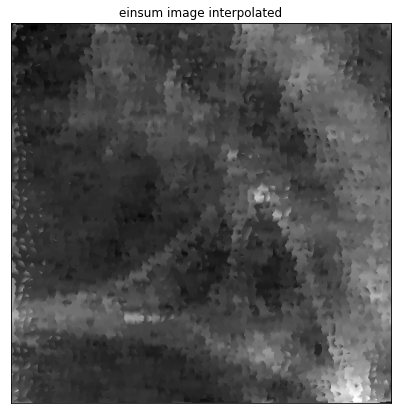

-1

In [7]:
#remove offset
im_numer = cv2.subtract(im_input, im_darkfld)

#normalise
im_div = cv2.divide(im_numer, im_denom)

im_div_masked = cv2.bitwise_and(im_div,im_div,mask = im_denom_masked)

# cv2.imshow('im div', im_div)
# cv2.imshow('im masked', im_div_masked)

# labeled_array, num_features = label(im_div_masked)

print('Before cores averaged')

ac_0 = time.time()
average_cores(core_arr_vals, core_arr_vals_bool, idxpts, im_div_masked, core_arr_x, core_arr_y, num_cores)
ac_1 = time.time()

print('After cores averaged')

nzarry, nzarrx = np.nonzero(im_div_masked)
values_known = im_div_masked[nzarry,nzarrx]    

#interpolate
int_0 = time.time()
np_im_input_fast_interpolate = M2.interpolate(values_known.flatten(), vtx, wts)
imginterp_fast = np_im_input_fast_interpolate.reshape(m,n)
int_1 = time.time()

print('Interpolation complete')


t_g=(time.time()-t0)
print(f'time taken to average cores: {ac_1-ac_0}')
print(f'time taken to interpolate: {int_1-int_0}')
print(f'total time taken: {t_g}')

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(imginterp_fast,cmap='gray')
plt.title('einsum image interpolated')
plt.show()

cv2.waitKey(0)

darkest: 20
brightest: 50


Text(0.5, 1.0, 'Adjusted Image')

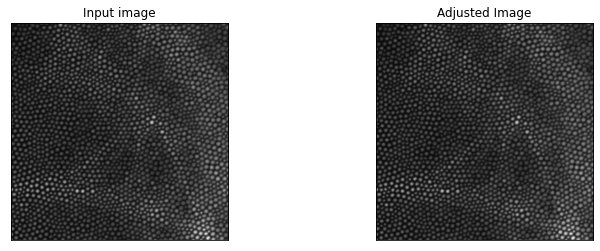

In [18]:
darkest = 20 #im_input.min()
brightest = 50 #im_input.max()
newImage = ((im_input - darkest)*256/(brightest-darkest))

print(f'darkest: {darkest}')
print(f'brightest: {brightest}')


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))


plt.sca(axs[0])
axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)
plt.imshow(im_input,cmap='gray')
plt.title('Input image')

plt.sca(axs[1])
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
plt.imshow(newImage,cmap='gray')
plt.title('Adjusted Image')


darkest: 0
brightest: 50


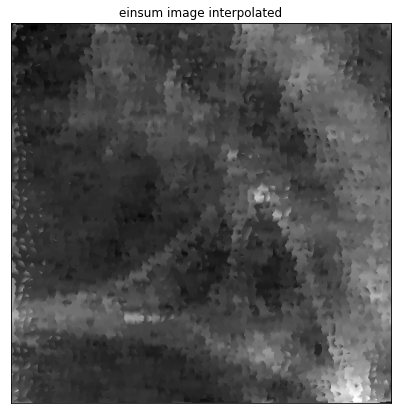

In [9]:
darkest = 0 #im_input.min()
brightest = 50 #im_input.max()
newvalue = ((imginterp_fast - darkest)*256/(brightest-darkest))

print(f'darkest: {darkest}')
print(f'brightest: {brightest}')

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(newvalue,cmap='gray')
plt.title('einsum image interpolated')
plt.show()